In [1]:
# Don't do this. Do as I say and not as I code.
import sys
sys.path.insert(0, "../") 

import numpy as np
import operator
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.decomposition import PCA

from mpl_utils import mpl_style

plt.style.use(mpl_style)

%matplotlib inline

In [2]:
galah = Table.read("../catalogs/GALAH_DR2.1_catalog.fits")

In [3]:
ignore_elements = ("k", )
element_label_names = [ln for ln in galah.dtype.names \
                       if ln.endswith("_fe") and not ln.startswith(("flag_", "e_", "alpha_")) \
                       and ln.split("_")[0] not in ignore_elements]
print("\n".join(element_label_names))
# Select a subset of stars and abundances
is_ok = dict()
for label_name in element_label_names:
    is_ok[label_name] = sum(galah["flag_{}".format(label_name)] == 0)
    
    use_element_label_names = [k for k, v in sorted(is_ok.items(), key=operator.itemgetter(1))[::-1]][:14]

meets_qc = (galah["flag_cannon"] == 0)
print(sum(meets_qc))
for label_name in use_element_label_names:
    meets_qc *= (galah["flag_{}".format(label_name)] == 0) \
              * (np.isfinite(galah[label_name]))
    print(label_name, sum(meets_qc))

use_element_label_names.append("fe_h")
    
N = sum(meets_qc)
D = len(use_element_label_names)
print("N = {0}, D = {1}".format(N, D))  

li_fe
c_fe
o_fe
na_fe
mg_fe
al_fe
si_fe
ca_fe
sc_fe
ti_fe
v_fe
cr_fe
mn_fe
co_fe
ni_fe
cu_fe
zn_fe
y_fe
ba_fe
la_fe
eu_fe
264227
na_fe 239580
mg_fe 226436
sc_fe 209213
ti_fe 195146
zn_fe 179550
mn_fe 169286
y_fe 155500
ca_fe 146109
ni_fe 134787
cr_fe 125124
o_fe 111499
si_fe 101675
ba_fe 88055
v_fe 76477
N = 76477, D = 15


In [4]:
# ONLY USE WHAT I TELL YU
use_element_label_names = ["fe_h", "ca_fe", "ti_fe", "si_fe", "ni_fe", 
                           "o_fe", "ba_fe", "y_fe", "eu_fe"]


meets_qc = (galah["flag_cannon"] == 0)
print(sum(meets_qc))
for label_name in use_element_label_names:
    if label_name == "fe_h": continue
    meets_qc *= (galah["flag_{}".format(label_name)] == 0) \
              * (np.isfinite(galah[label_name]))
    print(label_name, sum(meets_qc))

D = len(use_element_label_names)
N = sum(meets_qc)

264227
ca_fe 217755
ti_fe 203142
si_fe 171683
ni_fe 158182
o_fe 136152
ba_fe 115119
y_fe 106909
eu_fe 13146


In [5]:
y = np.array([galah[ln][meets_qc] for ln in use_element_label_names]).T

subsample = None

if subsample is not None:
    print("Sub-sampling only {} stars".format(subsample))
    idx = np.random.choice(y.shape[0], subsample, replace=False)
    y = y[idx]
    

fe_h_index = list(use_element_label_names).index("fe_h")
for d in range(D):
    if d == fe_h_index: continue
    y[:, d] += y[:, fe_h_index]
    
J = 3
N, D = y.shape


mean = np.mean(y, axis=0)
assert mean.size == D
y = y - mean

element_label_names = ["{}".format(ea.split("_")[0]) for ea in use_element_label_names]

latex_label_names = [r"\textrm{{{0}}}".format(ea.split("_")[0].title()) \
                     for ea in element_label_names]

In [6]:
pca = PCA(n_components=J)
pca.fit(y)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

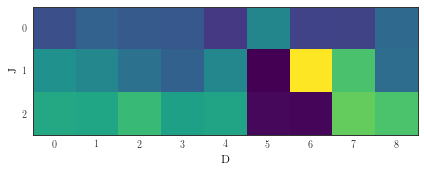

In [7]:
def plot_components(components, label_names=None, **kwargs):
    J, D = components.shape
    
    kwds = dict(interpolation="nearest")
    kwds.update(kwargs)
    
    fig, ax  =  plt.subplots()
    im = ax.imshow(components, **kwds)
    ax.yaxis.set_tick_params(width=0)
    ax.set_yticks(np.arange(J))
    ax.set_ylabel(r"\textrm{J}")
    
    ax.xaxis.set_tick_params(width=0)
    ax.set_xlabel(r"\textrm{D}")
    fig.tight_layout()
    
    if label_names is not None:
        ax.set_xticks(np.arange(D))
        ax.set_xticklabels(label_names)
    
    return  fig


fig = plot_components(pca.components_)# label_names=elements)

In [8]:
# Rank order the components.

In [9]:
C = np.abs(pca.components_.T)
C

array([[0.35737173, 0.03241616, 0.08710327],
       [0.26985301, 0.08500662, 0.0685695 ],
       [0.30999928, 0.19604617, 0.17746895],
       [0.31669146, 0.27546957, 0.04620914],
       [0.45299595, 0.08574676, 0.06633279],
       [0.08874753, 0.66034656, 0.63376166],
       [0.4118147 , 0.58014221, 0.64190359],
       [0.40595599, 0.22614294, 0.2883566 ],
       [0.23579375, 0.21515061, 0.22986324]])

In [10]:
#def rank_order_trilu(a):
#    """
#    Rank order the given array such that the entries in the
#    upper triangular matrix are closest to zero.
#    """
        
# Argsort them.
import numpy as  np
C = np.copy(C)
D, J = C.shape
idx = np.argsort(C.flatten())
ji = (idx / J).astype(int)
di = idx % J
print(idx)
print(ji)
print(di)

# We want the smallest value to have the upper right value, and then rank/sort from there.
def _swap(C, before, after):
    C = np.copy(C)
    b = np.copy(C[before])
    a = np.copy(C[after])
    C[before] = a
    C[after] = b
    return C
    

C = _swap(C.T, di[0], 2).T
C = _swap(C, ji[0], 0)

#swap_row()
#swap_column
C
    
    


[ 1 11 14  5  4 13  2 15  8  7 25 22 26 24  3 10 23  6  9  0 21 18 12 19
 17 20 16]
[0 3 4 1 1 4 0 5 2 2 8 7 8 8 1 3 7 2 3 0 7 6 4 6 5 6 5]
[1 2 2 2 1 1 2 0 2 1 1 1 2 0 0 1 2 0 0 0 0 0 0 1 2 2 1]


array([[0.35737173, 0.08710327, 0.03241616],
       [0.26985301, 0.0685695 , 0.08500662],
       [0.30999928, 0.17746895, 0.19604617],
       [0.31669146, 0.04620914, 0.27546957],
       [0.45299595, 0.06633279, 0.08574676],
       [0.08874753, 0.63376166, 0.66034656],
       [0.4118147 , 0.64190359, 0.58014221],
       [0.40595599, 0.2883566 , 0.22614294],
       [0.23579375, 0.22986324, 0.21515061]])

In [11]:
C = np.abs(pca.components_.T)

def rank_triu_matrix(C):
    Q = max(np.triu_indices_from(C, k=1)[1])

    ci, cj = (np.argsort(C), np.argsort(C.T))

    col_cumsum = np.array([np.cumsum(c.T[i]) for c, i in zip(C.T, cj)])
    col_indices = np.argsort(col_cumsum.T[Q])[::-1]
    
    C = np.copy(C).T[col_indices].T
    row_cumsum = np.array([np.cumsum(c[i]) for c, i in zip(C, ci)])

    row_indices = np.argsort(row_cumsum.T[Q])

    return (row_indices, col_indices)


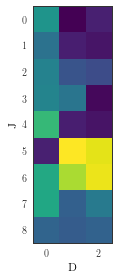

In [12]:
fig = plot_components(C)

In [13]:
ri, ci = rank_triu_matrix(C)
print(ci)
C_rank = C[ri][:, ci]
print(ri)
print(C)
print(C[:, ci])
print(C_rank)
#print(np.min(C))
#fig  = plot_components(C_rank, vmin=0, vmax=np.min(C[np.triu_indices_from(C, 1)]))

[0 1 2]
[1 0 4 3 8 2 7 5 6]
[[0.35737173 0.03241616 0.08710327]
 [0.26985301 0.08500662 0.0685695 ]
 [0.30999928 0.19604617 0.17746895]
 [0.31669146 0.27546957 0.04620914]
 [0.45299595 0.08574676 0.06633279]
 [0.08874753 0.66034656 0.63376166]
 [0.4118147  0.58014221 0.64190359]
 [0.40595599 0.22614294 0.2883566 ]
 [0.23579375 0.21515061 0.22986324]]
[[0.35737173 0.03241616 0.08710327]
 [0.26985301 0.08500662 0.0685695 ]
 [0.30999928 0.19604617 0.17746895]
 [0.31669146 0.27546957 0.04620914]
 [0.45299595 0.08574676 0.06633279]
 [0.08874753 0.66034656 0.63376166]
 [0.4118147  0.58014221 0.64190359]
 [0.40595599 0.22614294 0.2883566 ]
 [0.23579375 0.21515061 0.22986324]]
[[0.26985301 0.08500662 0.0685695 ]
 [0.35737173 0.03241616 0.08710327]
 [0.45299595 0.08574676 0.06633279]
 [0.31669146 0.27546957 0.04620914]
 [0.23579375 0.21515061 0.22986324]
 [0.30999928 0.19604617 0.17746895]
 [0.40595599 0.22614294 0.2883566 ]
 [0.08874753 0.66034656 0.63376166]
 [0.4118147  0.58014221 0.64190359

In [14]:
print(y.shape)
print(ri)
y = y[:, ri]
element_label_names = [element_label_names[i] for i in ri]
#data = dict(y=y, N=y.shape[0])

(13146, 9)
[1 0 4 3 8 2 7 5 6]


In [15]:
np.mean(y, axis=0)

array([-2.70250546e-19, -2.70250546e-18,  4.59425928e-18,  5.40501092e-18,
        2.43225491e-18,  1.08100218e-18,  3.24300655e-18, -1.51340306e-17,
       -2.16200437e-18])

In [16]:
data = dict(y=y, N=y.shape[0], D=y.shape[1], J=3)

In [17]:
import stan_utils as stan

default_op_kwds = dict(
    init_alpha=0.001,
    tol_obj=1e-12,
    tol_grad=1e-8,
    tol_param=1e-8,
    tol_rel_grad=1e7
)

op_kwds = default_op_kwds.copy()
op_kwds.update(
    iter=10000,
    data=data,
    tol_obj=1e-16,
    tol_grad=1e-16,
    tol_param=1e-16,
    tol_rel_grad=1e-16,
    init_alpha=1.0,
)

# TODO: Initialize from the PCA components?

model = stan.load_stan_model("../mlf.stan")
opt = model.optimizing(**op_kwds)

INFO:root:Using pre-compiled model from ../mlf.stan.cached
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [18]:
def calculate_factor_scores(opt, data):
    Ih = np.eye(data["J"])
    
    L = opt["L"]
    Wpsi = L.T / opt["psi"]
    cov_z = np.linalg.inv(Ih + np.dot(Wpsi, L))
    tmp = np.dot(data["y"], Wpsi.T)
    factor_scores = np.dot(tmp, cov_z)
    
    return factor_scores


In [19]:
factor_scores = calculate_factor_scores(opt, data)

In [20]:
# Plot the data.
from scipy.stats import binned_statistic_2d
from matplotlib.colors import LogNorm

def corner_hist(x, bins=30, label_names=None, show_ticks=False, **kwargs):
    N, D = x.shape
    A = D - 1
    fig, axes = plt.subplots(A, A, figsize=(2 * A, 2 * A))

    kwds = dict(cmap="Greys", norm=LogNorm())
    kwds.update(kwargs)
    
    for i, ax_row in enumerate(axes):
        for j, ax in enumerate(ax_row):
            if j >= i:
                ax.set_visible(False)
                continue

            H, xedges, yedges, binnumber = binned_statistic_2d(
                x.T[i], x.T[j], x.T[i], statistic="count", bins=bins)

            imshow_kwds = dict(
                aspect=np.ptp(xedges)/np.ptp(yedges), 
                extent=(xedges[0], xedges[-1], yedges[-1], yedges[0]))
            imshow_kwds.update(kwds)
            
            image = ax.imshow(H.T, **imshow_kwds)
            ax.set_ylim(ax.get_ylim()[::-1])
        

            if ax.is_last_row() and label_names is not None:
                ax.set_xlabel(label_names[j])
                
            if ax.is_first_col() and label_names is not None:
                ax.set_ylabel(label_names[i])
                
            if not show_ticks:
                ax.set_xticks([])
                ax.set_yticks([])
                
    fig.tight_layout()
    
    return fig


def corner_scatter(data, label_names=None, show_ticks=False, fig=None,
                   **kwargs):
    N, D = data.shape
    K = D 
    
    if fig is None:
        fig, axes = plt.subplots(K, K, figsize=(2 * K, 2 * K))
        
    else:
        axes = fig.axes
    
    kwds = dict(s=1, c="tab:blue", alpha=0.5)
    kwds.update(kwargs)
    
    axes = np.atleast_2d(axes).T
    
    for j, y in enumerate(data.T):
        for i, x in enumerate(data.T):
            
            try:
                ax = axes[K - i - 1, K - j - 1]
            
            except:
                continue
            
            if j >= i: 
                ax.set_visible(False)
                continue
            
            ax.scatter(x, y, **kwds)
            
            if not show_ticks:
                ax.set_xticks([])
                ax.set_yticks([])

            if ax.is_last_row() and label_names is not None:
                ax.set_xlabel(label_names[i])
                
            if ax.is_first_col() and label_names is not None:
                ax.set_ylabel(label_names[j])
                
    fig.tight_layout()
    
    return fig


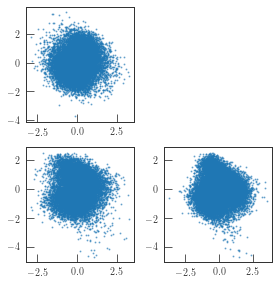

In [21]:
fig = corner_scatter(factor_scores, show_ticks=True)

(array([2., 1., 1., 0., 1., 0., 1., 0., 1., 2.]),
 array([7.14691066e-06, 2.36257453e-03, 4.71800214e-03, 7.07342976e-03,
        9.42885737e-03, 1.17842850e-02, 1.41397126e-02, 1.64951402e-02,
        1.88505678e-02, 2.12059955e-02, 2.35614231e-02]),
 <a list of 10 Patch objects>)

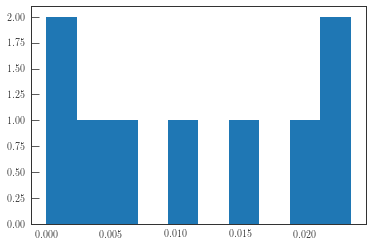

In [22]:
fig, ax = plt.subplots()
ax.hist(opt["psi"])

In [23]:
assert 0 

AssertionError: 

In [ ]:
plot_components(np.abs(opt["L"].T), vmin=0, vmax=1e-3)

In [ ]:
fig = plot_components(opt["L"].T)


In [ ]:
periodic_table = """H                                                  He
                    Li Be                               B  C  N  O  F  Ne
                    Na Mg                               Al Si P  S  Cl Ar
                    K  Ca Sc Ti V  Cr Mn Fe Co Ni Cu Zn Ga Ge As Se Br Kr
                    Rb Sr Y  Zr Nb Mo Tc Ru Rh Pd Ag Cd In Sn Sb Te I  Xe
                    Cs Ba Lu Hf Ta W  Re Os Ir Pt Au Hg Tl Pb Bi Po At Rn
                    Fr Ra Lr Rf"""

lanthanoids    =   "La Ce Pr Nd Pm Sm Eu Gd Tb Dy Ho Er Tm Yb"
actinoids      =   "Ac Th Pa U  Np Pu Am Cm Bk Cf Es Fm Md No"

periodic_table = periodic_table.replace(" Ba ", " Ba " + lanthanoids + " ") \
                               .replace(" Ra ", " Ra " + actinoids + " ") \
                               .split()
    
# Create an array of Z values for plotting, etc
Z = 1 + np.array([periodic_table.index(ln.split("_")[0].title()) for ln in element_label_names])
zi = np.argsort(Z)
ordered_element_label_names = [element_label_names[i].split("_")[0].title() for i in zi]

In [ ]:
fig, ax = plt.subplots()
ax.plot(Z[zi], opt["psi"][zi])
ax.set_xticks(Z[zi])
ax.set_xticklabels(ordered_element_label_names)

In [ ]:
fig, axes = plt.subplots(J, 1, figsize=(9, 9))
ax.set_xticks(Z[zi])
ax.set_xticklabels(ordered_element_label_names)
axes = np.atleast_1d(axes).flatten()

for j, ax in enumerate(axes):
    ax.plot(Z[zi], opt["L"].T[j][zi])
    ax.set_xticks(Z[zi])
    ax.set_xticklabels(ordered_element_label_names)
    

In [ ]:
from sklearn.decomposition import FactorAnalysis
fa = FactorAnalysis(3)
fa.fit(y)

In [ ]:
plot_components(fa.components_)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(opt["psi"], fa.noise_variance_)
limits = np.array([ax.get_xlim(), ax.get_ylim()])
limits = (np.min(limits), np.max(limits))
ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
ax.set_xlim(limits)
ax.set_ylim(limits)

In [ ]:
fig, axes = plt.subplots(J, 1, figsize=(3, 9))
for j, ax in enumerate(axes):
    ax.scatter(fa.components_[j], opt["L"].T[j])


In [ ]:
def calculate_factor_scores(opt, data):
    Ih = np.eye(data["J"])
    
    L = opt["L"]
    Wpsi = L.T / opt["psi"]
    cov_z = np.linalg.inv(Ih + np.dot(Wpsi, L))
    tmp = np.dot(data["y"], Wpsi.T)
    factor_scores = np.dot(tmp, cov_z)
    
    return factor_scores

fs = calculate_factor_scores(opt, data)

fa_scores = fa.transform(y)
fig, axes = plt.subplots(J, 1, figsize=(3, 9))
for j, ax in enumerate(axes):
    ax.scatter(fa_scores.T[j], fs.T[j])

In [ ]:
fig = corner_scatter(fs, alpha=0.05)

In [ ]:
fa_scores.shape

In [ ]:
factor_scores.shape

In [ ]:
ri, ci = rank_triu_matrix(fa.components_.T)

In [ ]:
plot_components(np.abs(D), vmin=0, vmax=1e-1)